## Аудит A/B-тестирования: Гарантия Стратегической Точности

**Аналитическая задача** — Проверка корректности проведенного AB-теста

### Задачи проекта:
- Оценка валидности проведенного A/B-теста.
- Выявление возможности использования результатов теста для создания стратегии.

### Описание проекта:
Имеется мобильное приложение для магазина по продаже продуктов питания. 

Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы провели A/B-тест.   

Пользователей разбили на 3 группы: 246 -- контрольная группа со старыми шрифтами; 247, 248 -- экспериментальная с новыми шрифтами.

### Описание данных:

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

### План по выполнению проекта:

Шаг 1. Загрузка данных
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовка данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Строим воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряется больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Считаем долю пользователей, совершивших каждое из событий.
- Проверяем гипотезу о наличие значимых отличий по результатам теста.

С помощью Yandex DataLens создаем дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе строим распределение количества событий по времени.

Шаг 1. Загрузка данных
- Знакомство с данными;
- Корректность a/b-теста.

In [1]:
# подключение библиотек

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import tenacity
import plotly
from plotly.files import PLOTLY_DIR, ensure_writable_plotly_dir

In [2]:
# загрузка данных
df = pd.read_csv('ab_testing.csv',
                 sep='\t')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
# информация о наборе данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.groupby('ExpId').DeviceIDHash.nunique()

ExpId
246    2489
247    2520
248    2542
Name: DeviceIDHash, dtype: int64

##### Проверяем корректность проведенного теста

In [5]:
# - объемы выборок по группам примерно совпадают -- количество уникальных субъектов по каждой группе, участвующих в эксперименте/тесте
df.groupby('ExpId').DeviceIDHash.nunique()

# - одни и те же клиенты не могут быть в разных группах
set_user_id_246 = set(df[df.ExpId == 247].DeviceIDHash) # множество уникальных id группы 246
set_user_id_248 = set(df[df.ExpId == 248].DeviceIDHash) # множество уникальных id группы 248

# проверим наличие общих клиентов в группах
set_user_id_246.intersection(set_user_id_248)

set()

##### <u>**Вывод:**</u>

Проведенный a/b-тест является корректным.

Шаг 2. Подготовка данные
- Корректировка заголовков;
- Проверка типов данных;
- Поиск аномалий и пропусков.

##### Предобработка

In [6]:
# исправление заголовков

df.columns = ['event_name', 'user_id', 'event_time', 'group_id']

In [7]:
# корректировка типов данных

df['event_time'] = pd.to_datetime(df['event_time'],
                                  unit='s',
                                  origin='unix')
df.head(2)

,event_name,user_id,event_time,group_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [8]:
# поиск дублей;
df.duplicated().sum()  # 413

# нашлось 413 дублей - удалим их
lst_user_id_dupl = list(df.loc[df.duplicated()].user_id.unique())
df.drop_duplicates(keep='last', inplace=True)

df.duplicated().sum()  

np.int64(0)

In [9]:
# поиск аномальных значений
# просмотр уникальных значений

lst_col = ['event_name', 'group_id']

def get_info_unique(lst:list):
    for col in lst_col:
        print(f'--- признак {col} ---')
        display(df[col].value_counts(ascending=False))
        print()

get_info_unique(lst_col)

--- признак event_name ---


event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64


--- признак group_id ---


group_id
248    85582
246    80181
247    77950
Name: count, dtype: int64

In [10]:
# событие -- Tutorial -- не имеет отношения к событиям покупки и его можно удалить
df.drop(index=df[df.event_name == 'Tutorial'].index,
        inplace=True)

In [11]:
# найдем количество посещений на каждого клиента
user_id_top_10 = df.groupby('user_id')\
                   .agg(count_visits = ('user_id', 'count'))\
                   .reset_index()\
                   .sort_values(by='count_visits',
                                ascending=False)\
                   .head(10)\
                   .user_id\
                   .to_list()

# проверим наличие клиентов из топ-10 по посещениям в списке с дублями

def get_index(lst_user_id_dupl:list, user_id_top_10:list) -> list:
    return [id for id in user_id_top_10 if id in lst_user_id_dupl]

# клиенты из топ-10 с дублями
get_index(lst_user_id_dupl, user_id_top_10)

# удалим их
index_del = df.loc[df.user_id.isin(get_index(lst_user_id_dupl, user_id_top_10))]\
              .index
df.drop(index=index_del,
        inplace=True)

##### <u>**Результат:**</u>

- Заголовки откорректированы
- Типы данных приведены в порядок
- Дкбли удалены
- Аномалии проработаны

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

In [12]:
print(f"""
Всего {df.event_name.nunique()} события -- {', '.join(df.event_name.unique())}.
Всего пользователей {df.user_id.nunique()}.
В среднем на пользователя приходится {int(df.shape[0] / df.user_id.nunique())} событий.""")


Всего 4 события -- MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear.
Всего пользователей 7540.
В среднем на пользователя приходится 30 событий.


In [13]:
# добавим признаки, связанные с датой

df['event_date'] = df['event_time'].dt.date
df.head(2)

,event_name,user_id,event_time,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


In [14]:
print(f"""Дата начала теста -- {df['event_date'].min()}
Дата окончания теста -- {df['event_date'].max()}""")

Дата начала теста -- 2019-07-25
Дата окончания теста -- 2019-08-07


C:\Users\Анюта\AppData\Local\Temp\ipykernel_18060\2189089193.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=8);


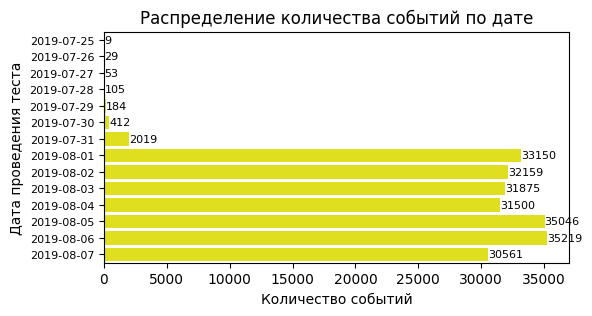

In [15]:
# Гистограмма по дате и количеству событий
plt.figure(figsize=(6,3))
ax = sns.countplot(data=df, y='event_date', color= 'yellow');
ax.set_title("Распределение количества событий по дате");
ax.set_ylabel("Дата проведения теста");
ax.set_xlabel("Количество событий");
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8);
ax.bar_label(ax.containers[0], fontsize=8);

Из диаграммы следует, что первую неделю тест фактически не проводился, посколько клиенты по неизвестной причине не совершали никаких событий.

##### <u>**Вывод:**</u>

Результаты, полученные в ходе теста, следует считать некорректными!

In [16]:
# Доделаем оставшиеся пункты проекта, предварительно удалив данные за первую неделю
df = df.loc[~(df.event_date <= dt.date(2019, 7, 31))].copy()

# проверка выполненной фильтрации
df.sort_values(by='event_date')

,event_name,user_id,event_time,group_id,event_date
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
26786,OffersScreenAppear,1832951734389458979,2019-08-01 15:37:30,246,2019-08-01
26785,MainScreenAppear,455812380260872971,2019-08-01 15:37:30,247,2019-08-01
26784,CartScreenAppear,1009745980451513098,2019-08-01 15:37:28,248,2019-08-01
26783,MainScreenAppear,2477577206728983149,2019-08-01 15:37:25,246,2019-08-01
...,...,...,...,...,...
223490,MainScreenAppear,1072623712787612806,2019-08-07 10:18:06,247,2019-08-07
223489,MainScreenAppear,5488760014591002030,2019-08-07 10:18:05,246,2019-08-07
223488,OffersScreenAppear,4612600107457375865,2019-08-07 10:18:04,248,2019-08-07
223500,PaymentScreenSuccessful,1072623712787612806,2019-08-07 10:18:15,247,2019-08-07


Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Строим воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряется больше всего пользователей?   
Какая доля пользователей доходит от первого события до оплаты?

In [17]:
# исключим клиентов 246 группы

index_orders_del = df[df.group_id == 246].index
df.drop(index=index_orders_del, inplace=True)
df.group_id.nunique()

2

In [18]:
# Распределение событий: какие события и в каком количестве.
# Сколько пользователей совершали каждое из этих событий?

df_funnel = df.groupby('event_name')\
              .agg(event_count=('user_id', 'count'),
                   event_user_id_unique=('user_id', 'nunique'))\
              .reset_index()\
              .sort_values(by='event_count', ascending=False)
df_funnel

,event_name,event_count,event_user_id_unique
1,MainScreenAppear,79393,4965
2,OffersScreenAppear,30799,3047
0,CartScreenAppear,24722,2464
3,PaymentScreenSuccessful,19248,2335


In [19]:
# визуализация воронки продаж
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = df_funnel['event_name'],
    x = df_funnel['event_user_id_unique'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

##### <u>**Вывод:**</u>

Из визуализации следует, что самая большая потеря пользователей происходит на этапе перехода с 'MainScreenAppear' к 'OffersScreenAppear'  
(чуть меньше 40%)

На дальнейших шагах воронки потеря пользвателей происхот намного плавнее

От первого события до оплаты доходит чуть меньше половины пользователей.

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Считаем долю пользователей, совершивших каждое из событий.
- Проверяем гипотезу о наличие значимых отличий по результатам теста.

In [20]:
# сколько пользователей в каждой группе

df.groupby('group_id').user_id.nunique().reset_index()

df.pivot_table(index='event_name',
               columns='group_id',
               values='user_id',
               aggfunc='nunique')\
               .reset_index()\
               .sort_values(by=247, ascending=False)

group_id,event_name,247,248
1,MainScreenAppear,2474,2491
2,OffersScreenAppear,1518,1529
0,CartScreenAppear,1236,1228
3,PaymentScreenSuccessful,1156,1179


In [21]:
# df_count_users
df_count_users = df.groupby('group_id')\
                   .user_id.nunique()
df_count_users.loc[247]

np.int64(2510)

In [22]:
df_pivot_event_group = df.pivot_table(index='event_name',
                                      columns='group_id',
                                      values='user_id',
                                      aggfunc='nunique')\
                         .reset_index()\
                         .sort_values(by=247, ascending=False)
df_pivot_event_group.columns = ['event_name', 'group_247', 'group_248']
df_pivot_event_group

,event_name,group_247,group_248
1,MainScreenAppear,2474,2491
2,OffersScreenAppear,1518,1529
0,CartScreenAppear,1236,1228
3,PaymentScreenSuccessful,1156,1179


In [23]:
# рассчитаем доли
for group_name in df_count_users.index:
    for col_name in ['group_247', 'group_248']:
        if col_name.find(str(group_name))>-1:
            df_pivot_event_group['part_users_'+str(group_name)] = np.round((df_pivot_event_group[col_name]
                                                                   / df_count_users.loc[group_name]),2)
df_pivot_event_group

,event_name,group_247,group_248,part_users_247,part_users_248
1,MainScreenAppear,2474,2491,0.99,0.98
2,OffersScreenAppear,1518,1529,0.60,0.60
0,CartScreenAppear,1236,1228,0.49,0.48
3,PaymentScreenSuccessful,1156,1179,0.46,0.47


In [24]:
df_pivot_event_group.set_index(df_pivot_event_group.event_name,
                               inplace=True)
df_pivot_event_group

,event_name,group_247,group_248,part_users_247,part_users_248
event_name,,,,,
MainScreenAppear,MainScreenAppear,2474,2491,0.99,0.98
OffersScreenAppear,OffersScreenAppear,1518,1529,0.60,0.60
CartScreenAppear,CartScreenAppear,1236,1228,0.49,0.48
PaymentScreenSuccessful,PaymentScreenSuccessful,1156,1179,0.46,0.47


In [25]:
# проверим гипотезу о наличие значимых отличий по результатам теста.
# для биноминальных распределений -- распределения Бернулли

def test_z_criterion(event_name, alpha):
    import scipy.stats as st
    import math

    n1 = df_count_users.loc[247]
    n2 = df_count_users.loc[248]

    m1 = df_pivot_event_group.loc[event_name, 'group_247']
    m2 = df_pivot_event_group.loc[event_name, 'group_248']

    z_value = (m1/n1 - m2/n2) / math.sqrt(((m1+m2)/(n1+n2))*(1-((m1+m2)/(n1+n2)))*(1/n1+1/n2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 #1-F(t)
    print('Результаты проверки гипотезы H_0 по z-критерию:')
    print('Уровень значимости alpha={:.2f}'.format(alpha))
    print('P-value: {:.2f}'.format(p_value))
    if p_value < alpha:
        print(f"""Отвергаем нулевую гипотезу: разница в долях
по событию <<{event_name}>> статистически значима.""")
    else: print(f"""Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<{event_name}>> статистически незначима.""")
    print('------------------------------------------------------------')

In [26]:
alpha = 0.05

for col in df_pivot_event_group['event_name'].unique():
    test_z_criterion(col, alpha)

Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.52
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<MainScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.93
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<OffersScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.59
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<CartScreenAppear>> статистически незначима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05
P-value: 0.73
Не получилось отвергнуть нулевую гипотезу: разница в долях по
событию <<PaymentScreenSuccessful>> с

##### <u>**Вывод:**</u>

Изначально тестирование прошло некорректно, нарушено деление трафика (по неизвестным причинам)

Отвергнуть нулевую гипотезу не удалось, разница между двумя группами отсутствует

Шаг 6. С помощью Yandex DataLens создаем дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе строим распределение количества событий по времени.

##### <u>**Результат:**</u>

[Ссылка](https://datalens.yandex/u80bmsnbfp6ih) на дашборд 